In [1]:
import tensorflow as tf

2024-02-15 17:38:33.667135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 17:38:33.667280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 17:38:33.967573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset",
    shuffle=True,
    batch_size=32,
    image_size=(128, 128),
)

Found 10000 files belonging to 100 classes.


In [12]:
labels = dataset.class_names
labels

['Abelmoschus Esculentus (Okra)',
 'Acorus Calamus (Dlingo)',
 'Aloe Vera (Lidah Buaya)',
 'Alstonia Scholaris (Pulai)',
 'Amaranthus Spinosus (Bayam Duri)',
 'Andrographis Paniculata (Sambiloto)',
 'Annona Muricata (Sirsak)',
 'Annona Squamosa (Srikaya)',
 'Anredera Cordifolia (Binahong)',
 'Apium Graveolens (Seledri)',
 'Artocarpus Heterophyllus (Nangka Mini)',
 'Artocarpus Integer (Nangka Cempedak)',
 'Averrhoa Bilimbi (Belimbing Wuluh)',
 'Blumea Balsamifera (Sembung)',
 'Borreria Hispida (Gempur Batu)',
 'Caesalpinia Sappan L (Secang)',
 'Caladium Cicolor (Keladi)',
 'Calendula Officinalis (Marigold)',
 'Canangium Odoratum (Kenanga)',
 'Catharanthus Roseus (Tapak Dara)',
 'Celosia Cristata (Jengger Ayam)',
 'Centella Asiatica (Pegagan)',
 'Cestrum Nocturnum (Sedap Malam)',
 'Citrus Amblycarpa (Jeruk Limau)',
 'Clinalanthus Nutans (Dandang Gendis)',
 'Clitoria Ternatea (Kembang Telang)',
 'Crinum Asiaticum (Bakung Putih)',
 'Curcuma Domestica (Kunyit)',
 'Cyclea Barbata (Cincau Hij

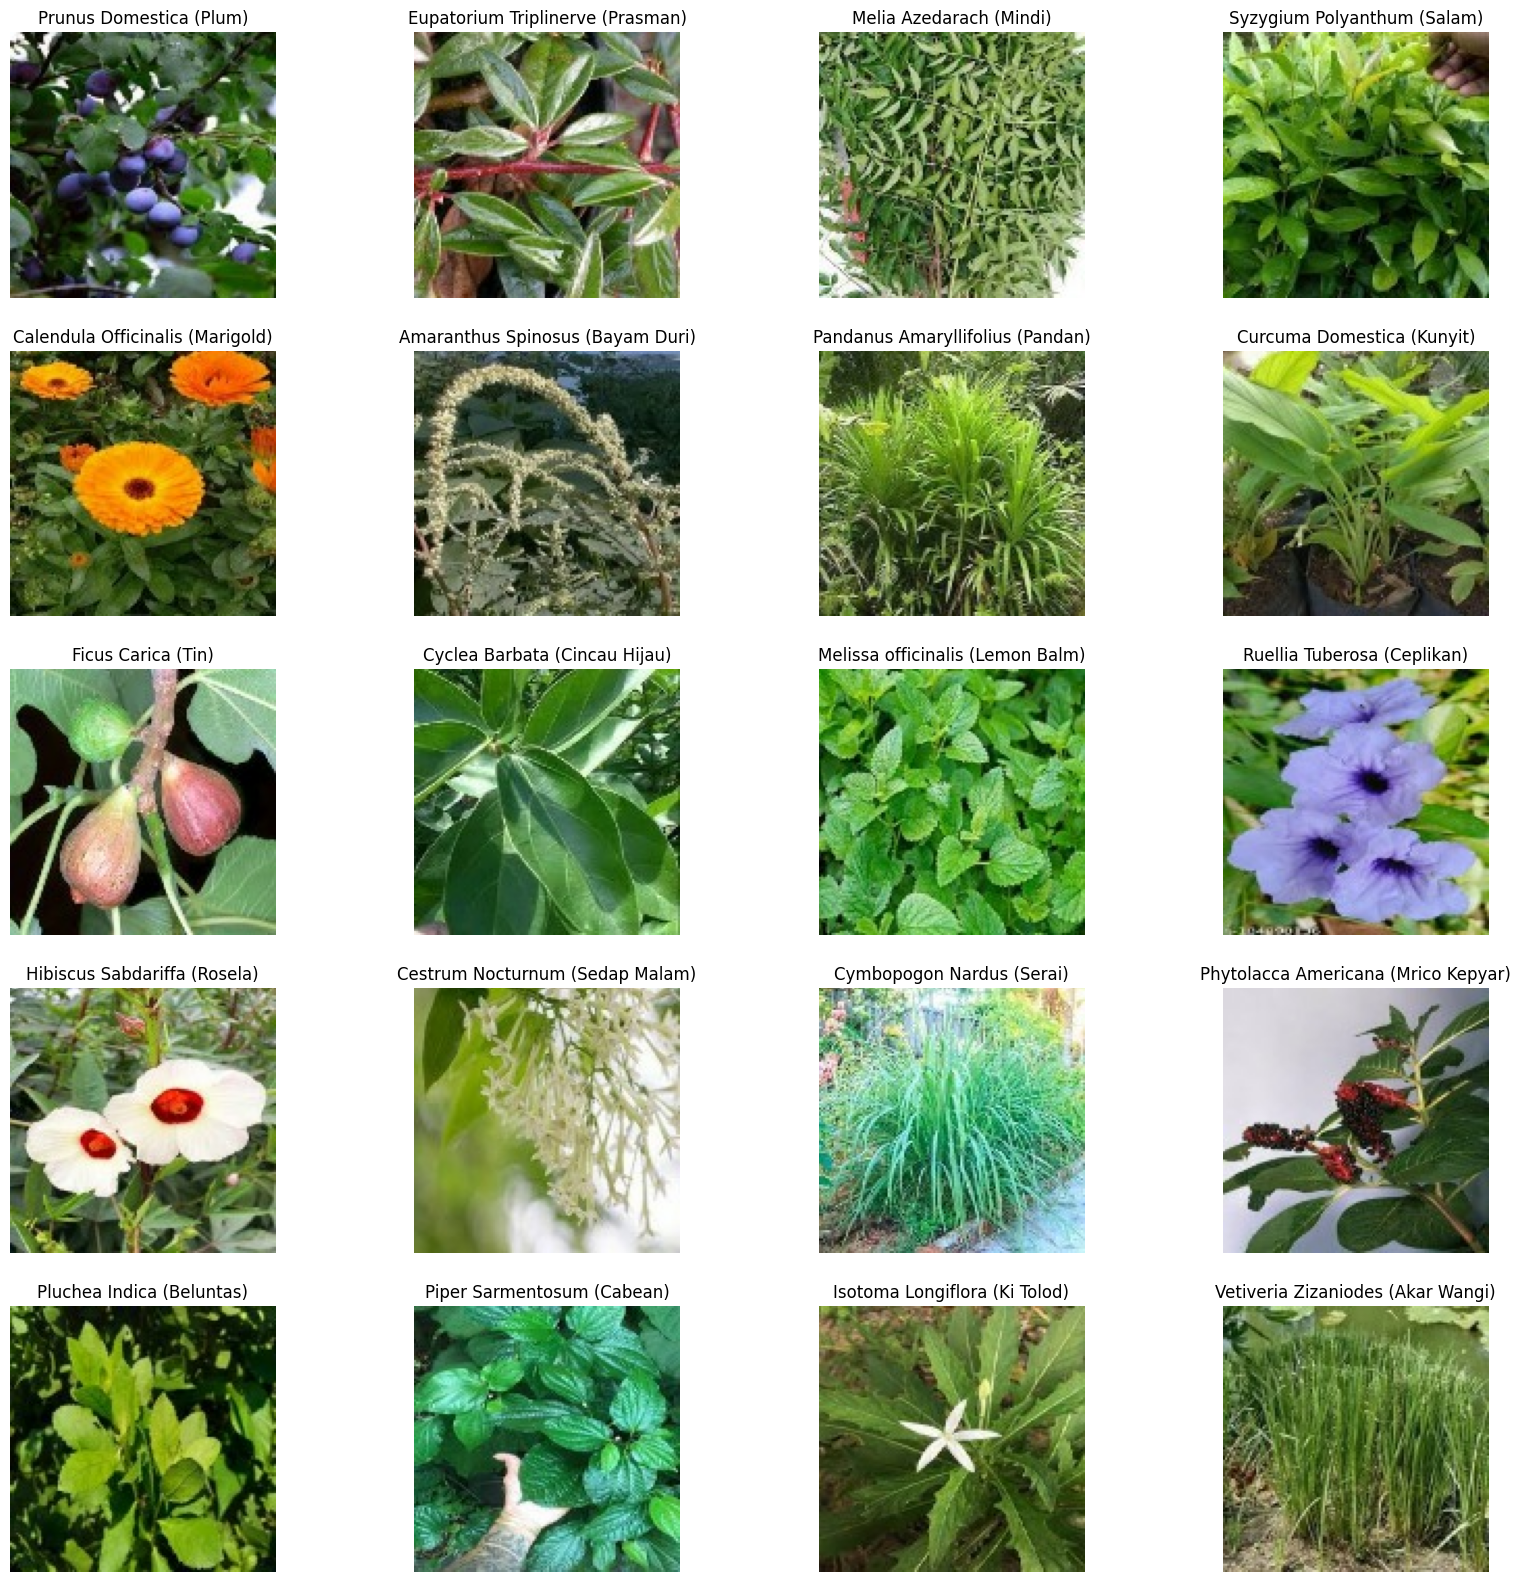

In [4]:
import matplotlib.pyplot as plt

class_names = dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)  # 5 rows, 4 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [5]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 128, 128, 3)
[66 64 58 82 93 61 23 31 35 65 96 27 52 23 80 35 91 22  7 70 19 81 64 37
 81 50 64 44  9 85 72  8]


In [13]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
#     assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(219, 32, 62)

In [15]:
rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19

feature_extractor = tf.keras.applications.VGG19( input_shape=(128,128,3),include_top=False, weights="imagenet", pooling='max')

In [17]:
for layer in feature_extractor.layers:
    layer.trainable=False
    
model = keras.Sequential([
        rescale,
        layers.BatchNormalization(),
        feature_extractor,
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(len(labels), activation='softmax')
        ])

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
model.build(input_shape = (None, 128, 128,3))
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                              patience = 3)


callback_list = [earlystopping]

model.summary()
model_history=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 40,
                        callbacks = callback_list)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 3)       12        
 chNormalization)                                                
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)              

In [18]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 [==============================] - 10s 50ms/step - loss: 0.5207 - accuracy: 0.9121
Test Loss: 0.5207
Test Accuracy: 0.9121


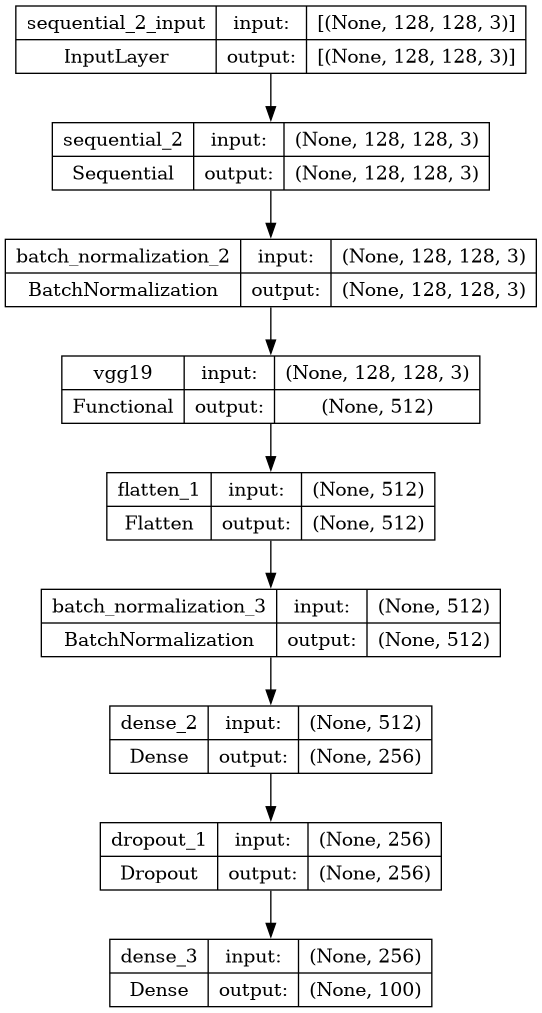

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True)

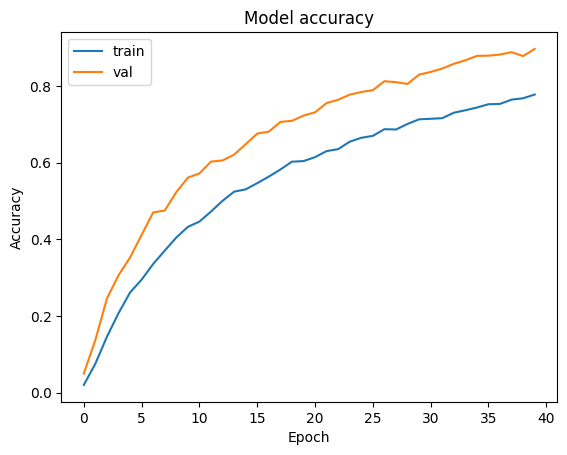

In [20]:
# plot accuracy
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

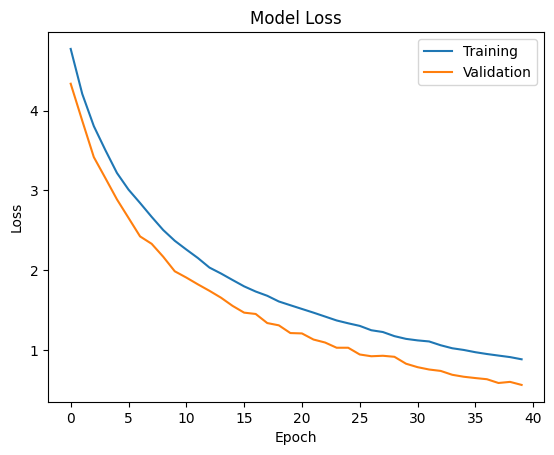

In [21]:
#Loss plot
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input

1/1 [==============================] - 1s 1s/step


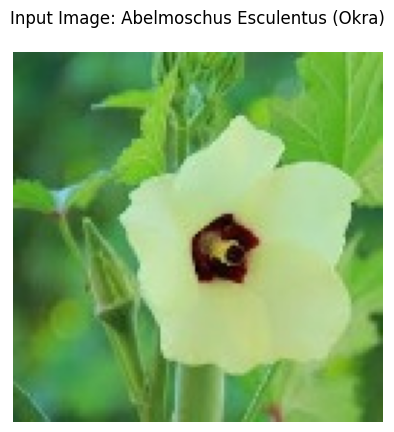

The image belongs to Abelmoschus Esculentus (Okra)


In [23]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Abelmoschus Esculentus (Okra)/16.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 21ms/step


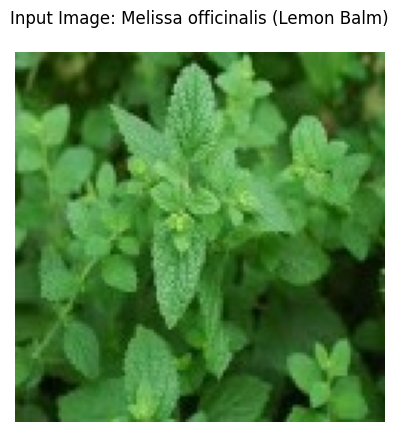

The image belongs to Melissa officinalis (Lemon Balm)


In [43]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Melissa officinalis (Lemon Balm)/90.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 19ms/step


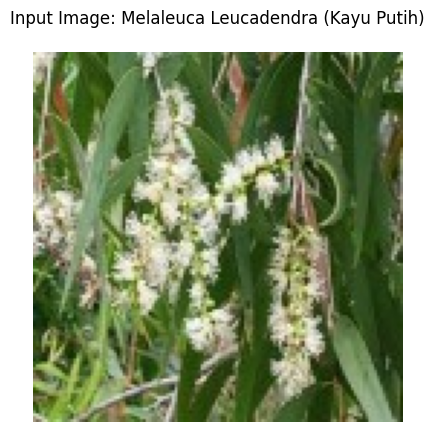

The image belongs to Melaleuca Leucadendra (Kayu Putih)


In [26]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Melaleuca Leucadendra (Kayu Putih)/16.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 19ms/step


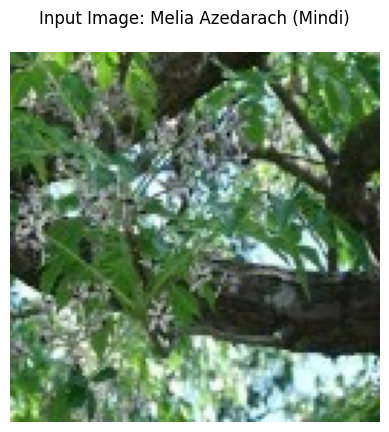

The image belongs to Melia Azedarach (Mindi)


In [28]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Melia Azedarach (Mindi)/59.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 20ms/step


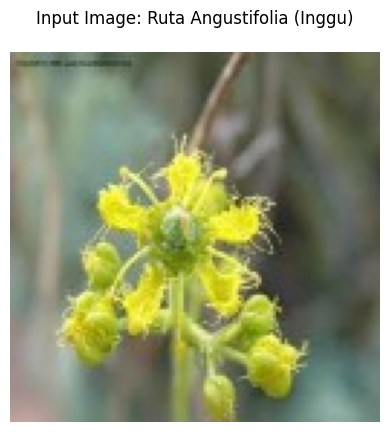

The image belongs to Ruta Angustifolia (Inggu)


In [30]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Ruta Angustifolia (Inggu)/45.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 20ms/step


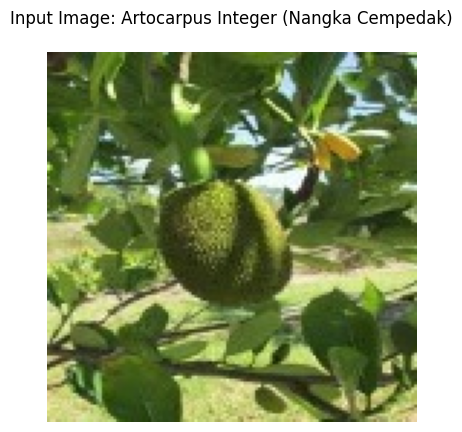

The image belongs to Artocarpus Integer (Nangka Cempedak)
1/1 [==============================] - 0s 23ms/step


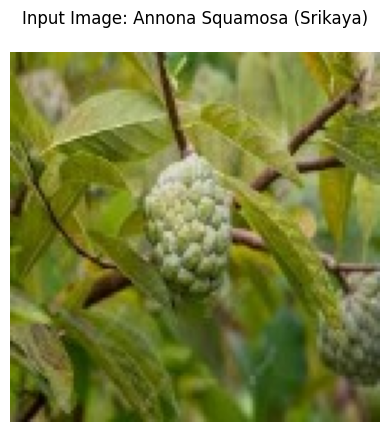

The image belongs to Annona Squamosa (Srikaya)
1/1 [==============================] - 0s 22ms/step


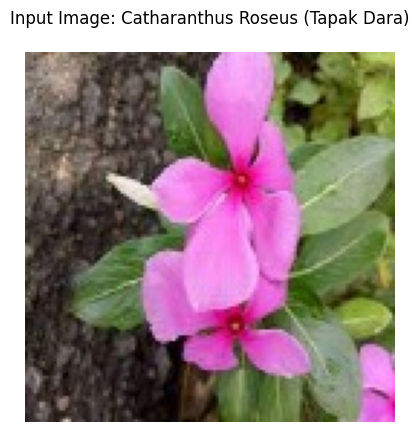

The image belongs to Catharanthus Roseus (Tapak Dara)
1/1 [==============================] - 0s 20ms/step


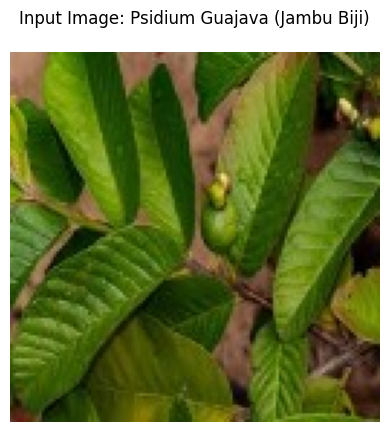

The image belongs to Blumea Balsamifera (Sembung)
1/1 [==============================] - 0s 19ms/step


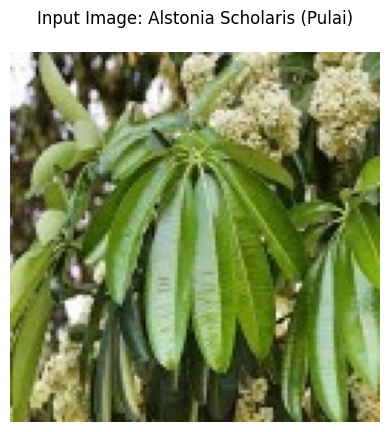

The image belongs to Alstonia Scholaris (Pulai)


In [48]:
import random
import glob
# Function to randomly select five images from the dataset
def get_random_images(dataset_path, num_images=5):
    all_images = glob.glob(os.path.join(dataset_path, '*/*.jpg'))
    random_images = random.sample(all_images, num_images)
    return random_images

# Load and predict for random images
random_images = get_random_images('/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset')

for img_path in random_images:
    img_name = os.path.basename(os.path.dirname(img_path))  
    img = load_img(img_path, target_size=(128, 128))  
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = labels[predicted_class_index]

    # Display the input image
    plt.imshow(img)
    plt.title(f"Input Image: {img_name}\n")
    plt.axis('off')
    plt.show()

    # Display the prediction
    confidence = 100 * np.max(tf.nn.sigmoid(predictions[0]))
    print(f"The image belongs to {predicted_class}")


In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels_batch in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate additional evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=labels)
acc_score = accuracy_score(y_true, y_pred)
rec_score = recall_score(y_true, y_pred, average='macro')
prec_score = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

32/32 [==============================] - 9s 51ms/step - loss: 0.5468 - accuracy: 0.9150
Test Loss: 0.5468
Test Accuracy: 0.9150
1/1 [==============================] - 0s 22ms/step


In [50]:
# Display the additional metrics
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[13  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0  8]]


In [51]:
print("\nClassification Report:")
print(class_report)


Classification Report:
                                              precision    recall  f1-score   support

               Abelmoschus Esculentus (Okra)       1.00      1.00      1.00        13
                     Acorus Calamus (Dlingo)       1.00      0.75      0.86         8
                     Aloe Vera (Lidah Buaya)       1.00      1.00      1.00        14
                  Alstonia Scholaris (Pulai)       0.80      1.00      0.89         8
            Amaranthus Spinosus (Bayam Duri)       0.90      0.82      0.86        11
         Andrographis Paniculata (Sambiloto)       0.88      0.88      0.88         8
                    Annona Muricata (Sirsak)       0.94      1.00      0.97        15
                   Annona Squamosa (Srikaya)       0.91      1.00      0.95        10
              Anredera Cordifolia (Binahong)       0.88      0.58      0.70        12
                  Apium Graveolens (Seledri)       0.69      1.00      0.82         9
      Artocarpus Heterophyllu

In [52]:
print("\nAccuracy Score:", acc_score)
print("Recall Score:", rec_score)
print("Precision Score:", prec_score)
print("F1 Score:", f1)


Accuracy Score: 0.888671875
Recall Score: 0.8855435814185814
Precision Score: 0.8928719613719613
F1 Score: 0.8821541473767079


In [53]:
model.save('/kaggle/working/vgg19_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
model.save('/kaggle/working/vgg19_model.keras')